In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
from xgboost import XGBRegressor

In [266]:
df = pd.read_excel("Carbon credit data set.xlsx")
df

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 13, 2025",$0.1784,$0.1911,$0.1395,$0.1531,"$163,635","$1,224,088"
1,"Jul 12, 2025",$0.1731,$0.1792,$0.172,$0.1784,"$6,122","$1,426,344"
2,"Jul 11, 2025",$0.1747,$0.1753,$0.1715,$0.1731,"$2,345","$1,384,004"
3,"Jul 10, 2025",$0.156,$0.1748,$0.1558,$0.1747,"$27,647","$1,397,357"
4,"Jul 09, 2025",$0.146,$0.156,$0.1459,$0.156,$919,"$1,247,707"
...,...,...,...,...,...,...,...
1358,"Oct 24, 2021","$3,287.97","$3,857.71","$2,881.49","$3,091.29","$49,888,170",$0
1359,"Oct 23, 2021","$3,289.88","$3,570.40","$3,002.40","$3,284.63","$58,575,888",$0
1360,"Oct 22, 2021","$2,369.98","$3,520.73","$2,320.01","$3,290.13","$71,415,952",$0
1361,"Oct 21, 2021","$2,231.66","$2,509.46","$1,826.51","$2,380.63","$38,089,980",$0


In [267]:
#EDA
print(df.head())

           Date     Open     High      Low    Close    Volume  Market Cap
0  Jul 13, 2025  $0.1784  $0.1911  $0.1395  $0.1531  $163,635  $1,224,088
1  Jul 12, 2025  $0.1731  $0.1792   $0.172  $0.1784    $6,122  $1,426,344
2  Jul 11, 2025  $0.1747  $0.1753  $0.1715  $0.1731    $2,345  $1,384,004
3  Jul 10, 2025   $0.156  $0.1748  $0.1558  $0.1747   $27,647  $1,397,357
4  Jul 09, 2025   $0.146   $0.156  $0.1459   $0.156      $919  $1,247,707


In [270]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        1363 non-null   object
 1   Open        1363 non-null   object
 2   High        1363 non-null   object
 3   Low         1363 non-null   object
 4   Close       1363 non-null   object
 5   Volume      1363 non-null   object
 6   Market Cap  1363 non-null   object
dtypes: object(7)
memory usage: 74.7+ KB
None


In [272]:
# Drop rows where all cells are empty
df.dropna(how="all", inplace=True)

In [274]:
print("Column names:", df.columns.tolist())

Column names: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']


In [276]:
#Strip whitespace and clean column names
df.columns = df.columns.str.strip().str.replace("*", "").str.replace(" ", "_")

In [278]:
# Convert relevant columns to numeric
cols_to_clean = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap']

In [280]:
for col in cols_to_clean:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r'[^\d\.\-]', '', regex=True)  
        .replace('', pd.NA)
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [282]:
# Drop rows where ALL numeric columns are NaN
df.dropna(subset=cols_to_clean, how='all', inplace=True)

In [284]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

In [286]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1363 entries, 1362 to 0
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1363 non-null   datetime64[ns]
 1   Open        1363 non-null   float64       
 2   High        1363 non-null   float64       
 3   Low         1363 non-null   float64       
 4   Close       1363 non-null   float64       
 5   Volume      1363 non-null   float64       
 6   Market_Cap  1363 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 85.2 KB
None


In [242]:
print("\n Summary statistics:\n")
print(df[cols_to_clean].describe())


 Summary statistics:

              Open         High          Low        Close        Volume  \
count  1363.000000  1363.000000  1363.000000  1363.000000  1.363000e+03   
mean     77.887026    84.791856    67.853490    76.424146  1.465418e+06   
std     369.716581   409.080479   321.159292   366.043983  5.903633e+06   
min       0.125300     0.126800     0.124200     0.125300  0.000000e+00   
25%       0.888900     0.907450     0.858150     0.886800  1.624850e+04   
50%       1.834800     1.865400     1.748600     1.818400  5.908600e+04   
75%       3.443250     3.673500     3.212800     3.437000  6.894425e+05   
max    3683.260000  3946.020000  3293.080000  3683.570000  7.294687e+07   

         Market_Cap  
count  1.363000e+03  
mean   4.080449e+06  
std    7.652200e+06  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    4.366704e+06  
max    3.556878e+07  


In [244]:
df['Daily_Return_%'] = df['Close'].pct_change(fill_method=None) * 100

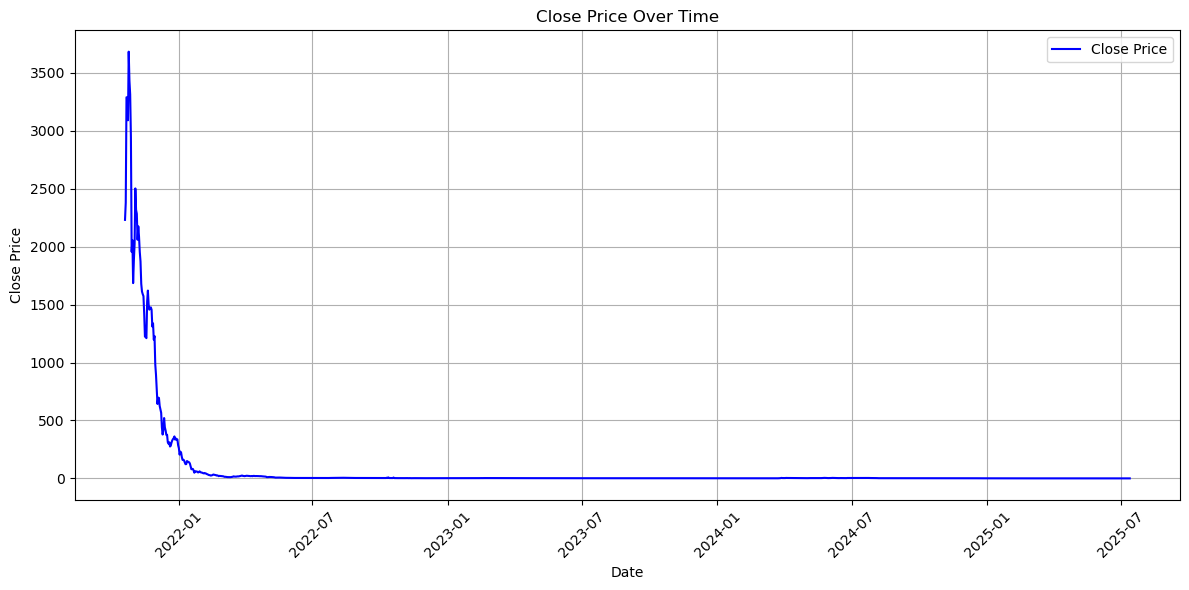

In [37]:
#Line Chart showing Closing Price Over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

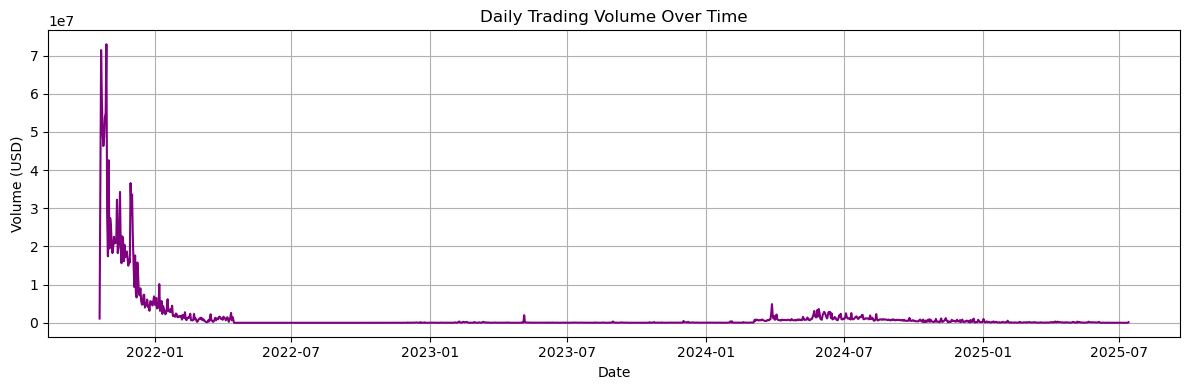

In [43]:
# Volume Trend
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Volume'], color='purple')
plt.title('Daily Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

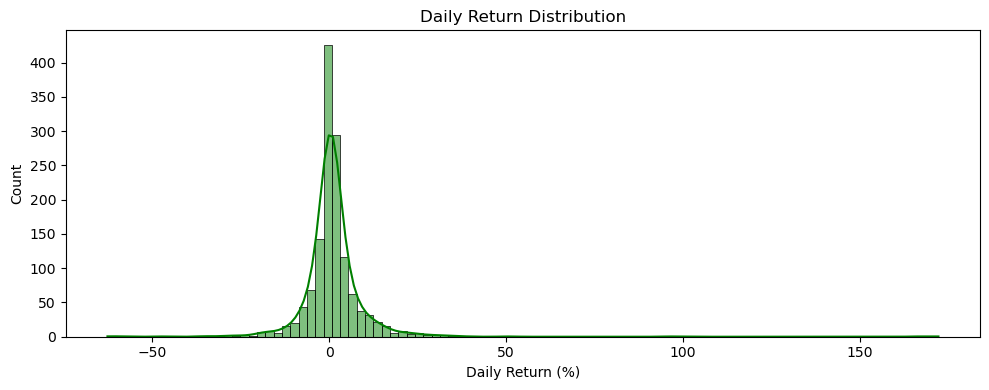

In [53]:
# Histogran of Daily Return Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['Daily_Return_%'].dropna(), bins=100, kde=True, color='green')
plt.title('Daily Return Distribution')
plt.xlabel('Daily Return (%)')
plt.tight_layout()
plt.show()

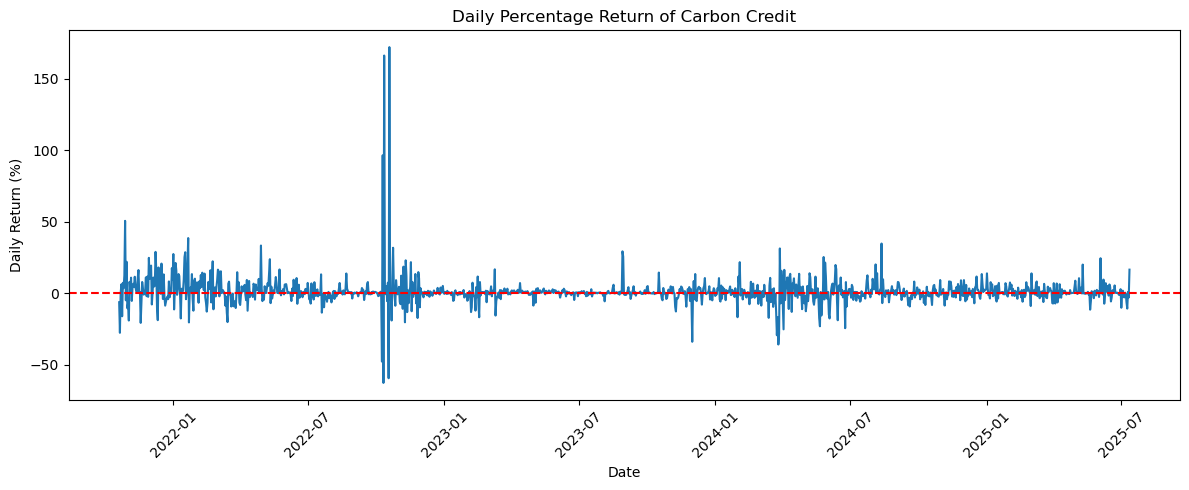

In [57]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='Date', y='Daily_Return_%')
plt.title('Daily Percentage Return of Carbon Credit')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

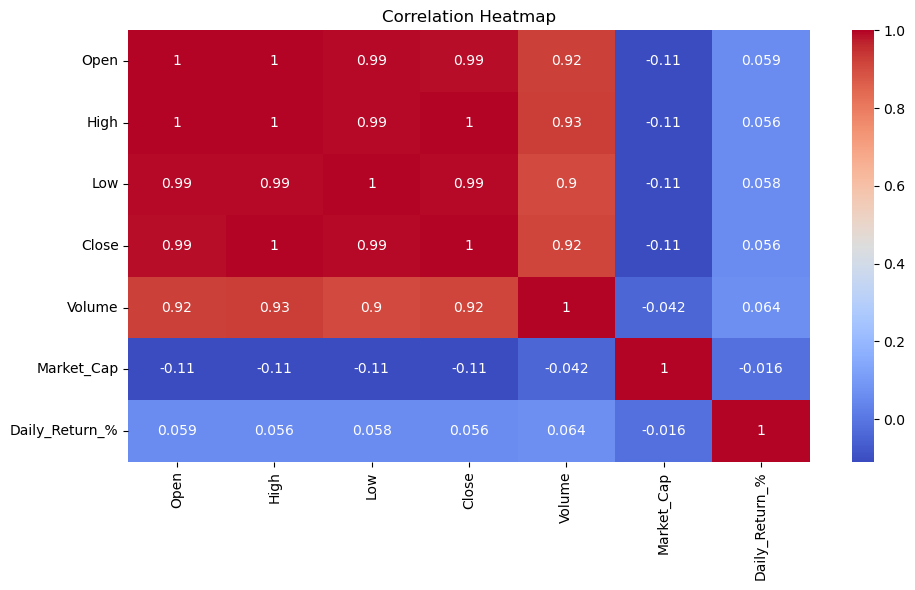

In [65]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap', 'Daily_Return_%']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

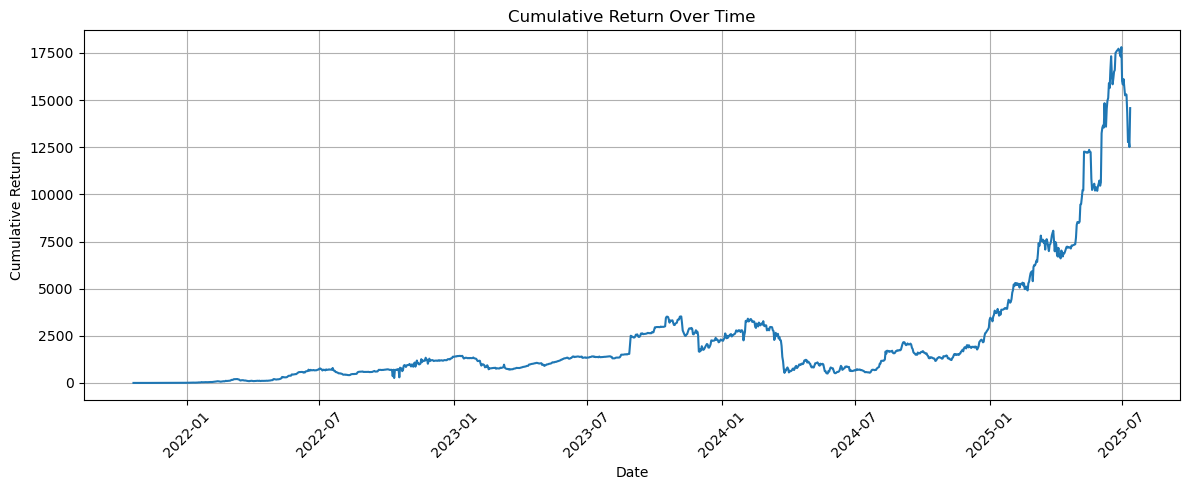

In [83]:
df['Cumulative Return'] = (1 + df['Daily_Return_%']/100).cumprod()

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='Date', y='Cumulative Return')
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Liquidity Analysis 
# Daily Returns 
df['Daily_Return'] = df['Close'].pct_change()
df['Abs_Return'] = df['Daily_Return'].abs()

# Amihud Illiquidity Ratio 
df['amihud_illiq'] = df['Abs_Return'] / df['Volume']
df['amihud_illiq'] = df['amihud_illiq'].replace([np.inf, -np.inf], np.nan)

# Turnover Ratio
df['turnover_ratio'] = df['Volume'] / df['Market_Cap']
df['turnover_ratio'] = df['turnover_ratio'].replace([np.inf, -np.inf], np.nan)

# Summary Statistics
liquidity_summary = df[['amihud_illiq', 'turnover_ratio']].describe()
print(liquidity_summary)

       amihud_illiq  turnover_ratio
count  1.336000e+03      509.000000
mean   3.052771e-03        0.048196
std    4.954965e-02        0.033072
min    0.000000e+00        0.000000
25%    4.174186e-08        0.024665
50%    1.724494e-07        0.042713
75%    1.066192e-06        0.066337
max    1.398698e+00        0.212872


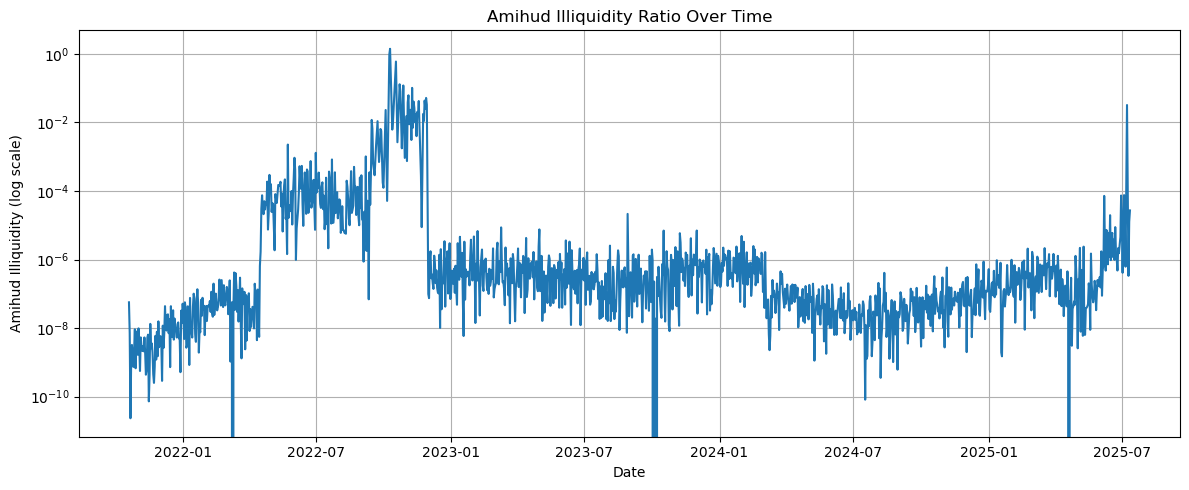

In [33]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=df['Date'], y=df['amihud_illiq'])
plt.yscale('log')
plt.title('Amihud Illiquidity Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Amihud Illiquidity (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

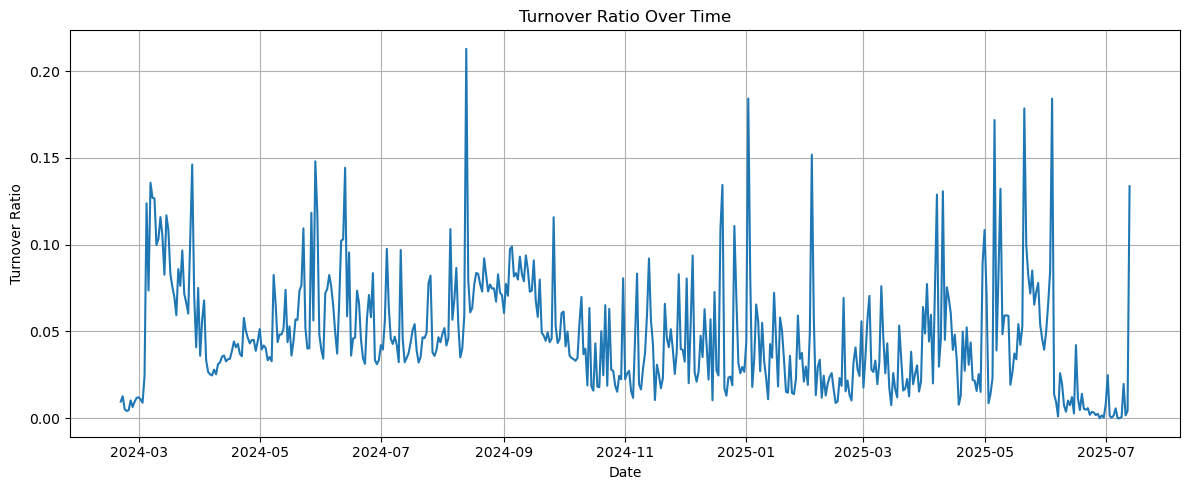

In [37]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=df['Date'], y=df['turnover_ratio'])
plt.title('Turnover Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Turnover Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

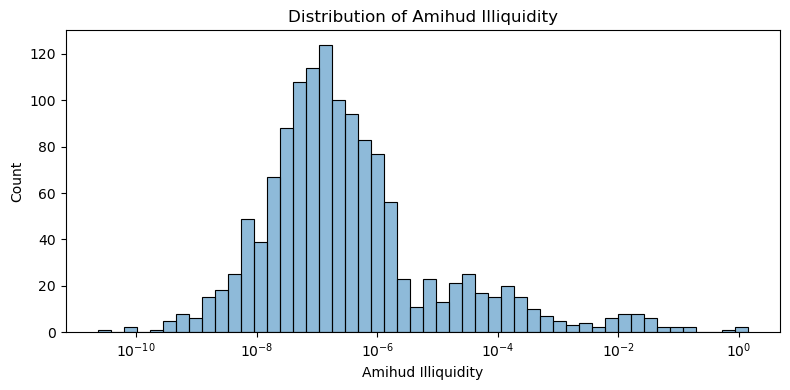

In [39]:
plt.figure(figsize=(8, 4))
sns.histplot(df['amihud_illiq'].dropna(), bins=50, log_scale=True, kde=True)
plt.title('Distribution of Amihud Illiquidity')
plt.xlabel('Amihud Illiquidity')
plt.tight_layout()
plt.show()

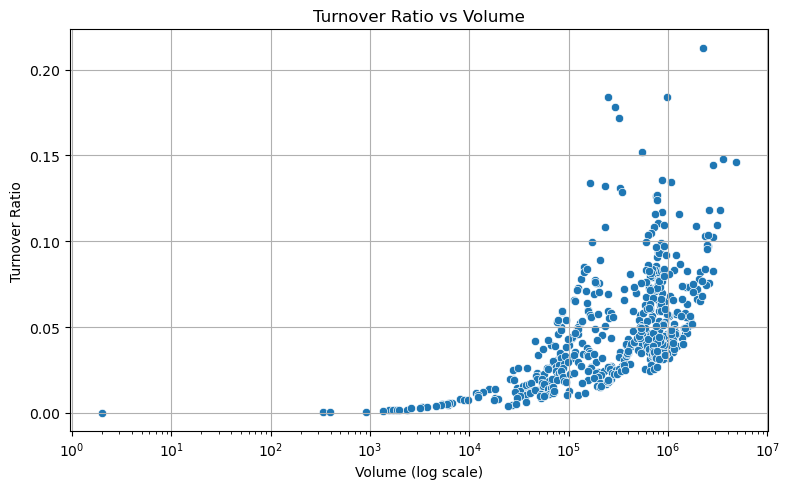

In [41]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Volume', y='turnover_ratio')
plt.xscale('log')
plt.title('Turnover Ratio vs Volume')
plt.xlabel('Volume (log scale)')
plt.ylabel('Turnover Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
#Predictive Modeling (Linear regression)
#Feature engineering 
df['Price_Range'] = df['High'] - df['Low']
df['Volatility'] = df['Daily_Return'].rolling(window=3).std()
df['Target_Close'] = df['Close'].shift(-1)  # Predicting next day's close

In [61]:
# Drop NaNs
df_model = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap',
                             'Daily_Return', 'Price_Range', 'Volatility', 'Target_Close'])

In [65]:
# Shift features to simulate real-time prediction
df_model.loc[:, features] = df_model[features].shift(1)

# Drop rows with NaNs again (caused by shift above)
df_model = df_model.dropna().copy()

In [67]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap',
            'Daily_Return', 'Price_Range', 'Volatility']
X = df_model[features]
y = df_model['Target_Close']

# Train-test split (no shuffling for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [69]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.2583
Mean Absolute Error: 0.3023
R² Score: 0.7665


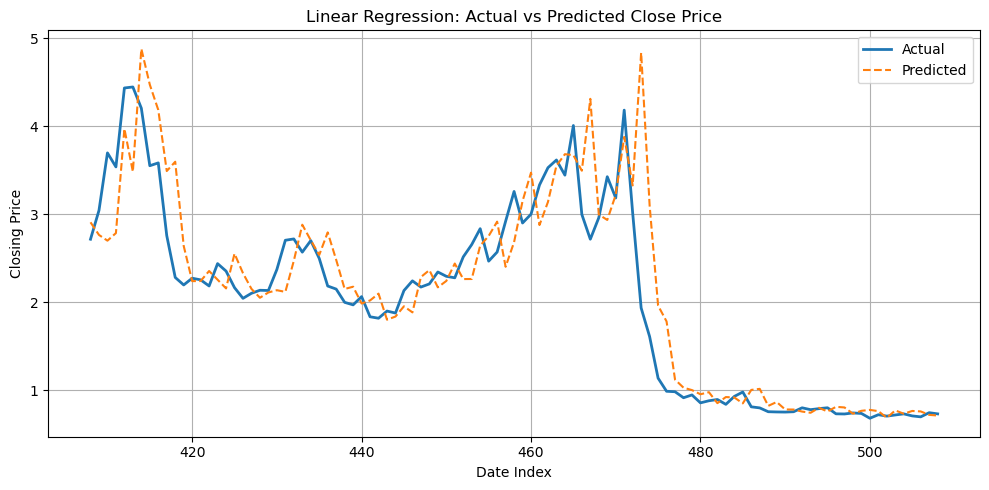

In [71]:
# Plot actual vs predicted (with index)
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.xlabel("Date Index")
plt.ylabel("Closing Price")
plt.title("Linear Regression: Actual vs Predicted Close Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

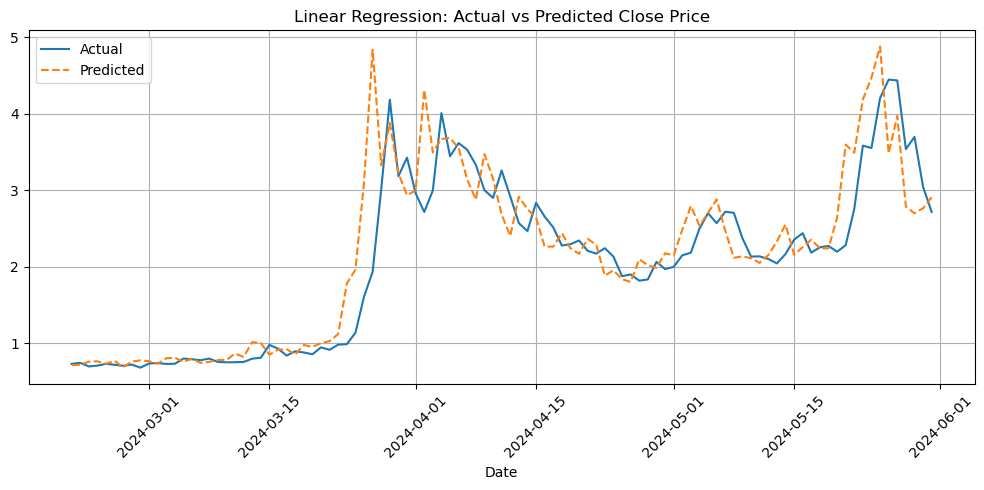

In [85]:
# Plot actual vs predicted ( with dates)
plt.figure(figsize=(10, 5))
plt.plot(df_model.loc[y_test.index, 'Date'], y_test, label='Actual')
plt.plot(df_model.loc[y_test.index, 'Date'], y_pred, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Linear Regression: Actual vs Predicted Close Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [25]:
#Time-series forecasting using Prophet

12:36:19 - cmdstanpy - INFO - Chain [1] start processing
12:36:20 - cmdstanpy - INFO - Chain [1] done processing


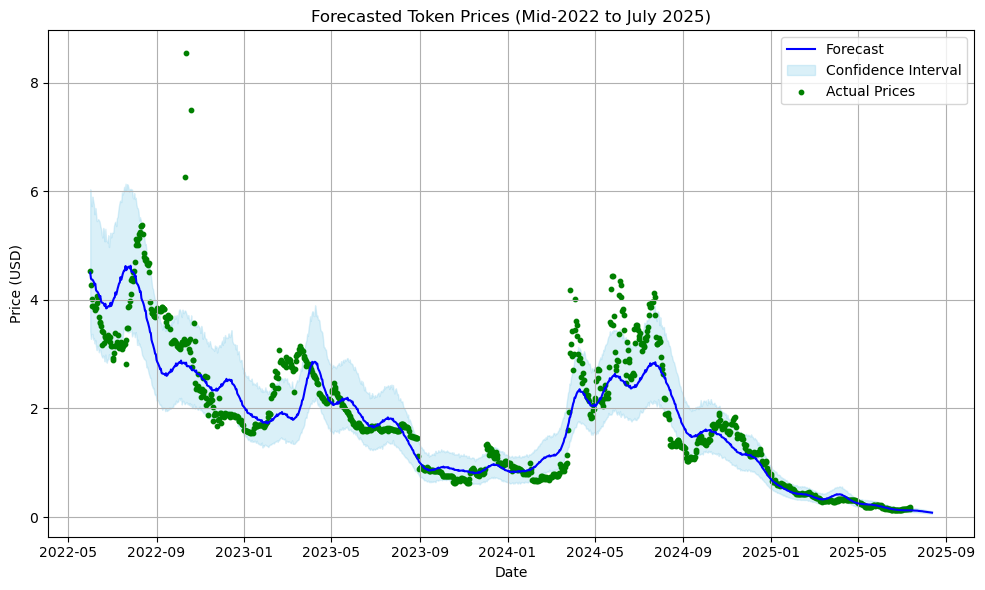

In [252]:
# Filter from mid-2022 onwards
df = df[df['Date'] >= '2022-06-01'].copy()

# Prepare for Prophet
df = df[['Date', 'Close']]
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Log-transform the price to avoid negative forecasts
df['y'] = np.log(df['y'])

# Build the model
model = Prophet()
model.fit(df)

# Make future dataframe
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Inverse the log transformation
forecast['yhat'] = np.exp(forecast['yhat'])
forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])

# Plot custom forecast and actuals
plt.figure(figsize=(10, 6))

# Plot forecasted values
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='skyblue', alpha=0.3, label='Confidence Interval')

# Plot actual observed values as green dots
plt.scatter(df['ds'], np.exp(df['y']), color='green', s=10, label='Actual Prices')

# Final plot touches
plt.title("Forecasted Token Prices (Mid-2022 to July 2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [254]:
# Show last 30 predicted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))

             ds      yhat  yhat_lower  yhat_upper
1139 2025-07-14  0.122290    0.092145    0.162505
1140 2025-07-15  0.121256    0.090742    0.160531
1141 2025-07-16  0.122463    0.092142    0.160988
1142 2025-07-17  0.119530    0.090225    0.157122
1143 2025-07-18  0.119139    0.088334    0.157731
1144 2025-07-19  0.119061    0.089859    0.158171
1145 2025-07-20  0.118488    0.089844    0.162226
1146 2025-07-21  0.117600    0.088382    0.157862
1147 2025-07-22  0.115912    0.089057    0.155007
1148 2025-07-23  0.116332    0.087689    0.155418
1149 2025-07-24  0.112810    0.083827    0.149702
1150 2025-07-25  0.111696    0.086464    0.151693
1151 2025-07-26  0.110879    0.081669    0.146959
1152 2025-07-27  0.109613    0.083686    0.146405
1153 2025-07-28  0.108081    0.080840    0.144184
1154 2025-07-29  0.105852    0.079370    0.140261
1155 2025-07-30  0.105584    0.079576    0.142109
1156 2025-07-31  0.101785    0.077336    0.136985
1157 2025-08-01  0.100219    0.076145    0.135052


In [256]:
# Train Prophet model
model = Prophet()
model.fit(df)

# Forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Inverse log transformation for comparison
forecast['yhat'] = np.exp(forecast['yhat'])

# Merge only the overlapping (actual) part
merged = forecast[['ds', 'yhat']].merge(df[['ds', 'y']], on='ds', how='inner')
merged['y_actual'] = np.exp(merged['y'])  # Back to original scale

# Calculate error metrics
mae = mean_absolute_error(merged['y_actual'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y_actual'], merged['yhat']))
mape = np.mean(np.abs((merged['y_actual'] - merged['yhat']) / merged['y_actual'])) * 100
r2 = r2_score(merged['y_actual'], merged['yhat'])

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 0.3445
Mean Absolute Percentage Error (MAPE): 17.65%
Root Mean Squared Error (RMSE): 0.5455
R² Score: 0.7969


In [298]:
#XGBOOST model
# Load your dataset (assumes df has 'Date' and 'Close' columns)
df = df.sort_values('Date').copy()

# Add lag features
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df['lag_3'] = df['Close'].shift(3)

# Drop rows with NaNs caused by shifting
df.dropna(inplace=True)

# Feature set and target
X = df[['lag_1', 'lag_2', 'lag_3']]
y = df['Close']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train XGBoost model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.2825
Root Mean Squared Error (RMSE): 0.3394
R² Score: 0.5693
